In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np
from keras.regularizers import l2
        

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [2]:
df = pd.read_parquet('../data/btcusd_preprcd_with_regimes.parquet')
df = df[df['smoothed_regimes'] == 1]
df.dropna(inplace=True)

NameError: name 'pd' is not defined

In [ ]:
print(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 257888 entries, 47 to 292662
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              257888 non-null  float64
 1   high              257888 non-null  float64
 2   low               257888 non-null  float64
 3   close             257888 non-null  float64
 4   BB_up_diff        257888 non-null  float64
 5   BB_down_diff      257888 non-null  float64
 6   OBV_Z             257888 non-null  float64
 7   MACD_Histogram    257888 non-null  float64
 8   RSI               257888 non-null  float64
 9   CCI               257888 non-null  float64
 10  predict_trend     257888 non-null  float64
 11  regime            257888 non-null  float64
 12  smoothed_regimes  257888 non-null  float64
dtypes: float64(13)
memory usage: 27.5 MB
None


open                0
high                0
low                 0
close               0
BB_up_diff          0
BB_down_diff        0
OBV_Z               0
MACD_Histogram      0
RSI                 0
CCI                 0
predict_trend       0
regime              0
smoothed_regimes    0
dtype: int64

In [ ]:
def preprocess_data(train_df):
    # Log-transform prices
    for col in ['open', 'high', 'low', 'close']:
        train_df[f'{col}_log_return'] = np.log(train_df[col] / train_df[col].shift(1))
    
    # Standard scaling for MACD and CCI
    std_cols = ['MACD_Histogram', 'CCI']
    std_scaler = StandardScaler().fit(train_df[std_cols])
    train_df[std_cols] = std_scaler.transform(train_df[std_cols])
    
    # MinMax for RSI (focus on 30–70 range)
    # train_df['RSI'] = np.clip(train_df['RSI'], 30, 70)
    # rsi_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[['RSI']])
    # train_df['RSI'] = rsi_scaler.transform(train_df[['RSI']])
    
    train_df.drop(columns=['open', 'high', 'low', 'close', 'smoothed_regimes'], inplace=True)
    train_df.dropna(inplace=True)
    return train_df

In [ ]:
df = preprocess_data(df)
sc = StandardScaler()
df['predict_trend'] = sc.fit_transform(df[['predict_trend']])

In [ ]:
df.head()

,BB_up_diff,BB_down_diff,OBV_Z,MACD_Histogram,RSI,CCI,predict_trend,regime,open_log_return,high_log_return,low_log_return,close_log_return
48,1.986388,-15.504388,0.753203,0.029921,69.736842,0.948745,-0.032520,1.0,0.001996,0.002316,0.000000,0.003951
49,3.822828,-14.153828,0.217083,0.027623,68.033813,0.638667,-0.022792,1.0,0.003410,0.007619,0.001037,-0.001819
50,4.948274,-13.282274,0.017523,0.023494,67.505436,0.458955,-0.009801,1.0,0.000200,-0.005340,0.000974,-0.000988
51,4.983098,-13.180098,0.068341,0.020422,60.794603,0.495102,0.000121,1.0,-0.003008,-0.001663,-0.003080,0.000587
52,4.526285,-13.324285,0.083305,0.019048,58.851298,0.678630,0.008964,1.0,-0.000124,-0.000370,0.000000,0.001281


In [ ]:
y = df['predict_trend']
x = df.drop(columns=['predict_trend'])
x_train = x[:int(len(x)*0.6)]
y_train = y[:int(len(x)*0.6)]
x_val = x[int(len(x)*0.6):int(len(x)*0.8)]
y_val = y[int(len(x)*0.6):int(len(x)*0.8)]
x_test = x[int(len(x)*0.8):]
y_test = y[int(len(x)*0.8):]

In [ ]:
x_train = np.nan_to_num(x_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
x_val = np.nan_to_num(x_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
y_train.shape

(154732,)

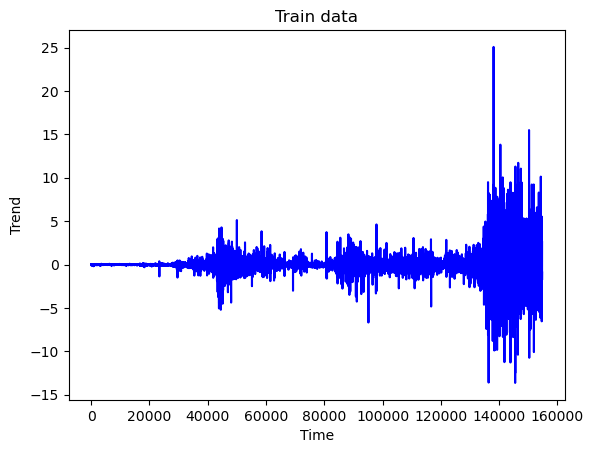

In [ ]:
sns.lineplot(data=y_train, color='blue')

plt.title('Train data')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()


In [ ]:
from keras.regularizers import l2

model = Sequential()
model.add(LSTM(50, activation='linear', input_shape=(x_train.shape[1], 1), return_sequences=False, kernel_regularizer=l2(0.01)))
# model.add(LSTM(50, activation='linear', return_sequences=False))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=1)

Epoch 1/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 16.1549

2025-03-19 00:40:48.518453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


4836/4836 ━━━━━━━━━━━━━━━━━━━━ 416s 86ms/step - loss: 16.1534 - val_loss: 1.9391
Epoch 2/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 425s 88ms/step - loss: 1.3008 - val_loss: 1.2682
Epoch 3/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 434s 90ms/step - loss: 0.5862 - val_loss: 1.2540
Epoch 4/5
4836/4836 ━━━━━━━━━━━━━━━━━━━━ 444s 92ms/step - loss: 0.4987 - val_loss: 1.2489
Epoch 5/5
1634/4836 ━━━━━━━━━━━━━━━━━━━━ 5:05 95ms/step - loss: 0.4783

In [ ]:
model.save('../models/sideways_market_model2.h5')

In [ ]:
# from keras.metrics import MeanSquaredError

# custom_objects = {'mse': MeanSquaredError()}

# model_n = tf.keras.models.load_model('../models/sideways_market_model.h5', custom_objects=custom_objects)

y_pred = model.predict(x_test)


2025-03-19 00:11:58.419262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step


In [ ]:
print(y_pred[0])

[[0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]
 [0.01529159]]


In [ ]:
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test = sc.inverse_transform(np.array(y_test).reshape(-1, 1))

In [ ]:
y_pred[0]

array([4.823605], dtype=float32)

In [ ]:
threshold = 500
signals_pred = np.where(y_pred > threshold, 1, np.where(y_pred < -threshold, -1, 0)).astype(int)
signals_test = np.where(y_test > threshold, 1, np.where(y_test < -threshold, -1, 0)).astype(int)

In [ ]:
data = pd.DataFrame({
    'Index': range(len(y_test)),
    'y_test': y_test.flatten(),  # Use .values to get NumPy array
    'y_pred': y_pred.flatten()   # Use .values to get NumPy array
})

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_test', label='Actual (y_test)', color='blue')
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

ValueError: All arrays must be of the same length

In [ ]:
print("Unique values in signals_test:", np.unique(signals_test))
print("Unique values in signals_pred:", np.unique(signals_pred))

Unique values in signals_test: [-1  0  1]
Unique values in signals_pred: [-1  0  1]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(signals_test, signals_pred, labels=[-1, 0, 1]))
print(confusion_matrix(signals_test, signals_pred, labels=[-1, 0, 1]))

              precision    recall  f1-score   support

          -1       0.10      0.00      0.01       598
           0       0.98      0.99      0.99     50346
           1       0.07      0.04      0.05       634

    accuracy                           0.97     51578
   macro avg       0.38      0.34      0.35     51578
weighted avg       0.96      0.97      0.96     51578

[[    2   577    19]
 [   16 50029   301]
 [    3   608    23]]
